In [1]:
import json
from utils.all import *

# Allows interactive plotting
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9], preprocess=True, realign_ids=False)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_kelly.json']

Found users: {'ayush', 'vishnesh', 'anton', 'kelly', 'rachel', 'vinayak'}

anton - Batch 5, HIT 38 (ID 37) has 2 deleti

In [3]:
# Get the percentile of a score among some systems
get_percentile(data, 14.56)['all']

{'new-wiki-1/T5-11B': 100.0,
 'new-wiki-1/Muss': 85.02994011976048,
 'new-wiki-1/Human 2 Writing': 66.07142857142857,
 'new-wiki-1/T5-3B': 98.96907216494846,
 'new-wiki-1/GPT-3-few-shot': 69.61325966850829,
 'new-wiki-1/GPT-3-zero-shot': 80.0,
 'new-wiki-1/Human 1 Writing': 72.7810650887574}

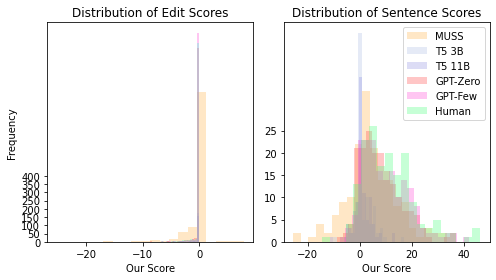

In [4]:
import random

systems = set([x['system'] for x in data])

n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(7, 4))

for system in [s for s in all_system_labels if s in systems and 'Human' not in s]:
    annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if sent['system'] == system] for x in y], key=lambda x: x['score'])
    axs[0].hist([x['score'] for x in annotations], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])
    axs[1].hist([x['score'] for x in data if x['system'] == system], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])

# Only human annotations
annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if 'Human' in sent['system']] for x in y], key=lambda x: x['score'])
edit_scores, sent_scores = [x['score'] for x in annotations], [x['score'] for x in data if 'Human' in x['system']]
axs[0].hist(random.sample(edit_scores, int(len(edit_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 1 Writing'])
axs[1].hist(random.sample(sent_scores, int(len(sent_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])

axs[0].set_yticks(np.arange(0, 401, 50))
axs[1].set_yticks(np.arange(0, 26, 5))

axs[0].set_title("Distribution of Edit Scores")
axs[1].set_title("Distribution of Sentence Scores")

axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Our Score")
axs[1].set_xlabel("Our Score")

axs[1].legend()

out_filename = f'img/score-distributions.svg'
plt.savefig(out_filename, format="svg", bbox_inches='tight', pad_inches=0.0)
plt.show()


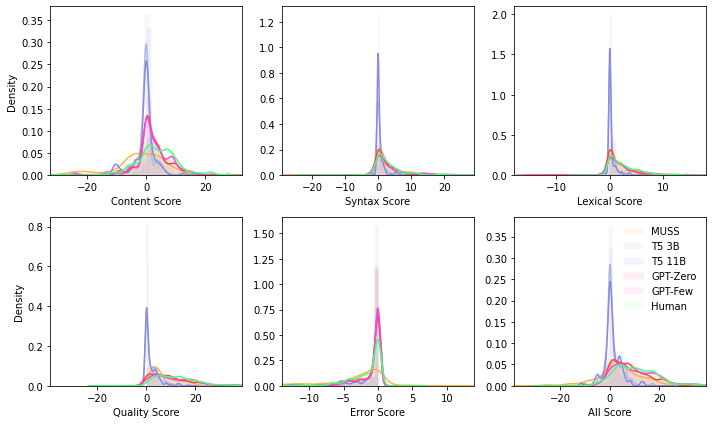

In [5]:
import pandas as pd

fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
n_bins = 20
bw_method = 0.2
systems = set([x['system'] for x in data])

for j, segmentation in enumerate([['content', 'syntax', 'lexical'], ['quality', 'error', 'all']]):
    for i, dim in enumerate(segmentation):
        score_dim = f'{dim}'

        for system in [s for s in all_system_labels if s in systems and 'Human' not in s]:
            sent_scores = [x['subscores'][score_dim] for x in data if x['system'] == system]
            s = pd.Series(sent_scores)
            axs[j, i] = s.plot.hist(ax=axs[j, i], bins=n_bins, density=True, edgecolor='w', linewidth=0.5, alpha=0.1, label=system_name_mapping[system], color=color_mapping[system])
            axs[j, i] = s.plot.density(ax=axs[j, i], color=color_mapping[system], alpha=1, bw_method=bw_method)
            ax = plt.gca()

        sent_scores = [x['subscores'][score_dim] for x in data if 'Human' in x['system']]
        s = pd.Series(random.sample(sent_scores, int(len(sent_scores)/2)))
        axs[j, i] = s.plot.hist(ax=axs[j, i], bins=n_bins, density=True, linewidth=0.5, alpha=0.1, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])
        axs[j, i] = s.plot.density(ax=axs[j, i], color=color_mapping['new-wiki-1/Human 2 Writing'], alpha=1, bw_method=bw_method)

        xlim, ylim = axs[j, i].get_xlim(), axs[j, i].get_ylim()
        axs[j, i].set_xlim((-max(xlim)/2, max(xlim)/2))
        axs[j, i].set_ylim(ylim)

        axs[j, i].set_xlabel(f'{dim.capitalize()} Score')
        axs[j, i].set_ylabel("")

    axs[j, 0].set_ylabel("Density")
axs[1, 2].legend(frameon=False)
out_filename = f'img/performance-distribution.svg'
plt.savefig(out_filename, format="svg", bbox_inches='tight', pad_inches=0.0)
plt.show()

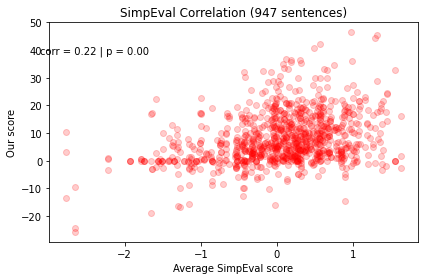

In [6]:
# Graph agreement with SimpEval
data = calculate_sentence_scores(data)
simpeval_agreement(data)

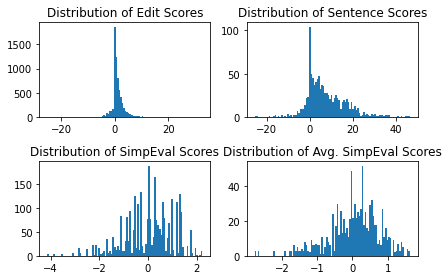

In [7]:
# Show the distribution of edit and sentence scores
score_distribution(data, include_simpeval=True)

In [7]:
# This is my first time using iPy, so this is a bit clunky...
def series(
    data, 
    average, 
    user,
    good_deletion=default_params['good_deletion'], 
    good_trivial_insertion=default_params['good_trivial_insertion'], 
    good_insertion=default_params['good_insertion'], 
    good_paraphrase=default_params['good_paraphrase'], 
    good_syntax=default_params['good_syntax'], 
    grammar_error=default_params['grammar_error'], 
    content_error=default_params['content_error'], 
    size_calculation=default_params['size_calculation'],
    display_distribution=False
    ):
    params = {
        'good_deletion': good_deletion,
        'good_trivial_insertion': good_trivial_insertion,
        'good_insertion': good_insertion,
        'good_paraphrase': good_paraphrase,
        'good_syntax': good_syntax,
        'grammar_error': grammar_error,
        'content_error': content_error,
        'size_calculation': size_calculation
    }

    selected_data = data
    if user != 'all':
        selected_data = [sent for sent in selected_data if sent['user'] == user]

    selected_data = calculate_sentence_scores(selected_data, params)
    simpeval_agreement(selected_data, average)
    if (display_distribution):
        score_distribution(selected_data)
    return()

interact(
    series, 
    data=[data], 
    good_deletion=(-20,20,0.5), 
    good_trivial_insertion=(-20,20,0.5), 
    good_insertion=(-20,20,0.5), 
    good_paraphrase=(-20,20,0.5), 
    good_syntax=(-20,20,0.5), 
    grammar_error=(-20,20,0.5), 
    content_error=(-20,20,0.5),
    size_calculation=['linear', 'log', 'square', 'none'],
    average=[True, False],
    user=['all'] + sorted(list(set([sent['user'] for sent in data]))),
    display_distribution=[True, False]
)

interactive(children=(Dropdown(description='data', options=([{'id': 0, 'original': "The architecture of Winche…

<function __main__.series(data, average, user, good_deletion=7, good_trivial_insertion=8, good_insertion=2, good_paraphrase=2, good_syntax=3, grammar_error=-1, content_error=-2, size_calculation='log', display_distribution=False)>